In [1]:
# The gp_sfh.py file conta"ins a simple GP framework that we'll be using
from gp_sfh import *
import gp_sfh_kernels

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

from tqdm import tqdm

from copy import deepcopy
import hickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

/home/iyer/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def makeplot(fig, axs, axins, case1, kernelcolor, labelval, **kernelargs):

    axs[0].plot(case1.tarr, case1.kernel(case1.tarr, **kernelargs),lw=3,color=kernelcolor,label=labelval,zorder=100)
    axs[0].set_xlabel('$|\Delta (t-t\')|$ [Gyr]')
    axs[0].set_ylabel('ACF [(dex)$^2$]')
    axs[0].set_xscale('log')
    axs[0].set_xlim(np.amin(case1.tarr),np.amax(case1.tarr))
    
    axs[1].plot(case1.tarr, case1.samples[0],color=kernelcolor)
    axs[1].set_xlim(0,np.amax(case1.tarr));
    axs[1].set_ylim(-4,3)
    axs[1].set_xlabel('time [Gyr]')
    axs[1].set_ylabel('log SFR(t) [M$_\odot$yr$^{-1}$]')
    
    axins.plot(case1.tarr, case1.samples[0],color=kernelcolor)
    # sub region of the original image
    x1, x2, y1, y2 = 2.5,3.0, -1.08,1.08
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    #axins.set_yticklabels('')
    axs[1].indicate_inset_zoom(axins, edgecolor="black")

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 330.13it/s]


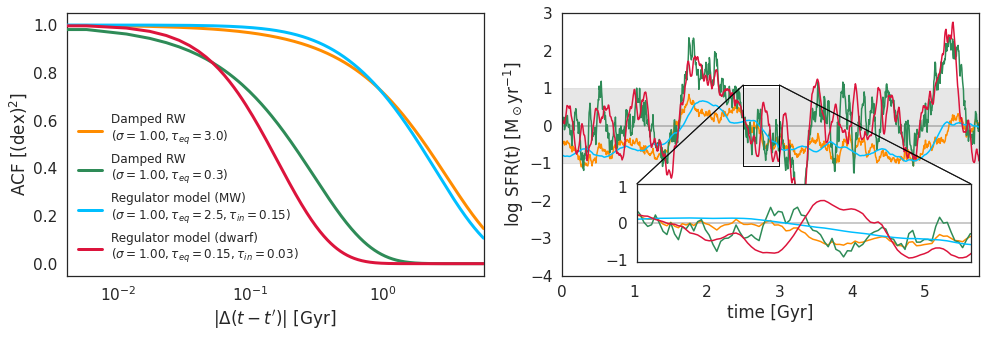

In [3]:
case1 = simple_GP_sfh(sp=sp, cosmo=cosmo)
case1.zval = 1.0
case1.get_tarr(n_tarr = 1000)
case1.get_basesfh(sfhtype='const')

nsamp = 1000
random_seed = 42

fig, axs = plt.subplots(1,2,figsize=(14,5))
axins = axs[1].inset_axes([0.18, 0.05, 0.8, 0.3])

axs[1].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
axins.plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)

axs[1].fill_between(case1.tarr, np.ones_like(case1.tarr),np.ones_like(case1.tarr)*(-1.),color='k',alpha=0.1)

#------------------------------------------------------

case1.kernel = gp_sfh_kernels.damped_random_walk_kernel
kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=3.0)
makeplot(fig, axs, axins, case1, 'darkorange', 'Damped RW\n'+r'($\sigma=%.2f,\tau_{eq}=3.0$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=3.0)

kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=0.3)
makeplot(fig, axs, axins, case1, 'seagreen', 'Damped RW\n'+r'($\sigma=%.2f,\tau_{eq}=0.3$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=0.3)

#------------------------------------------------------

case1.kernel = gp_sfh_kernels.regulator_model_kernel
kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=2.5, tau_in = 0.15)
makeplot(fig, axs, axins, case1, 'deepskyblue', 
                                     'Regulator model (MW)\n'+r'($\sigma=%.2f,\tau_{eq}=2.5,\tau_{in}=0.15$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=2.5, tau_in = 0.15)

kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=0.15, tau_in = 0.03)
makeplot(fig, axs, axins, case1, 'crimson', 
                                     'Regulator model (dwarf) \n'+r'($\sigma=%.2f,\tau_{eq}=0.15,\tau_{in}=0.03$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=0.15, tau_in = 0.03)

axs[0].legend(edgecolor='w',fontsize=12,loc=3,framealpha=0.1)
plt.tight_layout()
plt.savefig('figures/diffkernels_SFH_example.png',bbox_inches='tight')
plt.show()